<a href="https://colab.research.google.com/github/Henil28P/EmbryoClassificationModel/blob/main/Assignment2PartI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code block below is used to connect your Colab notebook to your google drive. You MUST run it BEFORE running other codes if you want to use files in your drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/dataset/embryo-dateset

/content/drive/Shareddrives/dataset/embryo-dateset


# Assessment 2: Introduction to AI

- Leonardo Rodriguez Magana : 14429346
- Kevin Ly
- Henil Patel : 24505289

Import all relevant packages and libraries of Python and also modules in the Google Drive.

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

Dataset is located in a sharedrive.
- embryo-dataset



In [ ]:
cd /content/gdrive/Shareddrives/dataset/embryo-dateset

/content/gdrive/Shareddrives/dataset/embryo-dateset


Dataset containes 2 folders:
- test
- train

In [ ]:
ls

model.png  test/  train/


In [ ]:
# Function to get images
def read_ct_scan(folder_name):
    """Read the scan image files from directory"""
    images = []

    # Construct path for two image file folders
    filepaths = [os.path.join(folder_name,file) for file in os.listdir(folder_name) if file != '.DS_Store']

    # Read image file in each folder and convert them to RGB channel
    for file in filepaths:
        images.append(np.array(Image.open(file).convert('RGB')))

    return images


Getting training images
- 0 = embryo is no good
- 1 = embryo

In [ ]:
base_path = os.path.join(os.getcwd(), 'train')

not_good_embryo = read_ct_scan(os.path.join(base_path, '0'))
good_embryo = read_ct_scan(os.path.join(base_path, '1'))

print('Total number of images: ')
print('Good: ', len(good_embryo))
print('No good: ', len(not_good_embryo))

Total number of images: 
Good:  99
No good:  573


### Examples of good Embryo: 1

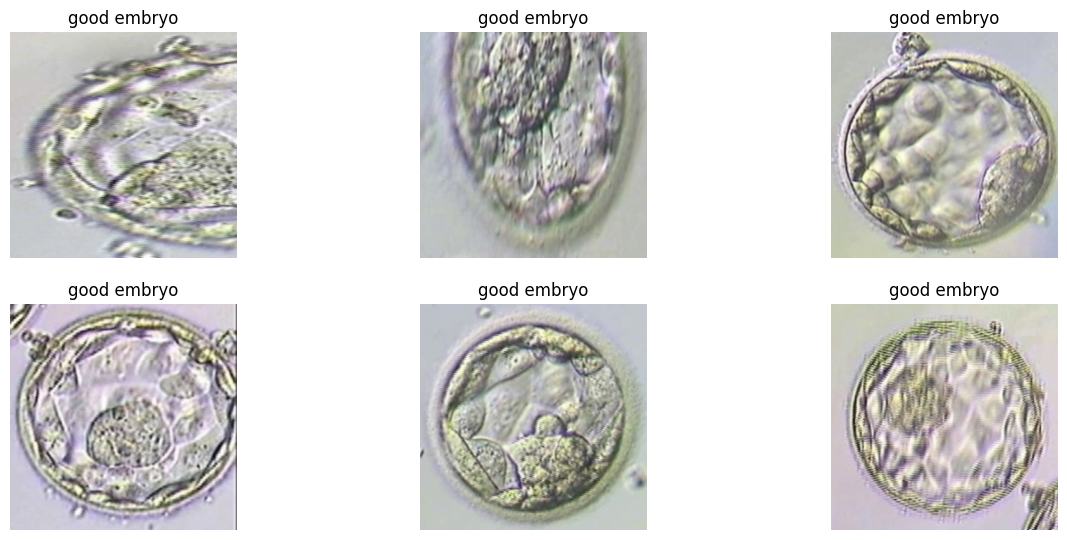

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(good_embryo[i]/255.)
    plt.axis("off")
    plt.title('good embryo')

### Example of a bad embryo: 0

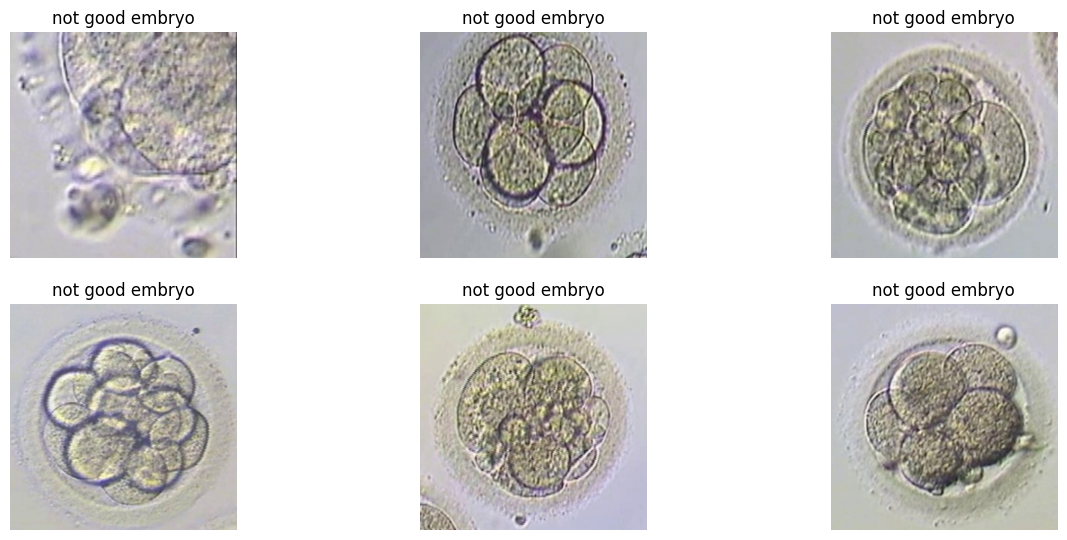

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(not_good_embryo[i]/255.)
    plt.axis("off")
    plt.title('not good embryo')

Let's create binary label for good embryo and bad embryo

In [ ]:
notGood_labels = np.full(len(not_good_embryo),fill_value=0)
good_labels = np.full(len(good_embryo),fill_value=1)

## Train-validation split

In [ ]:
from sklearn.model_selection import train_test_split

X = np.concatenate((good_embryo, not_good_embryo))
y = np.concatenate((notGood_labels, good_labels))

X_train, X_val, y_train, y_val = train_test_split(
    X,y,
    test_size = 0.2,
    random_state=42
)

print('Train-validation split:')
print('{} training images and {} validation images'.format(len(X_train), len(X_val)))

Train-validation split:
537 training images and 135 validation images


## Data Augmentation

Using `tf.keras.Sequential` to create a pipeline in which the input image is randomly transformed through the following operations:
1. Random horizontal and vertical flip
2. Rotation by a random degree in the range of $[-5\%, 5\%]*2\pi$
3. Random zoom in height by $5\%$
4. Random translation by $5\%$
5. Random contrast adjustment by $5\%$

In [ ]:
# Define global variables
IMG_SIZE = 512 # Standardize all images to this size
BATCH_SIZE = 32 # Number of training images for each gradient update


In [ ]:
# Data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])


In [ ]:
def preprocess_image(image, label):
    # Convert to float32 and resize image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]
    return image, label

# Augmentation function
def augment(image, label):
    image = data_augmentation(image)
    return image, label

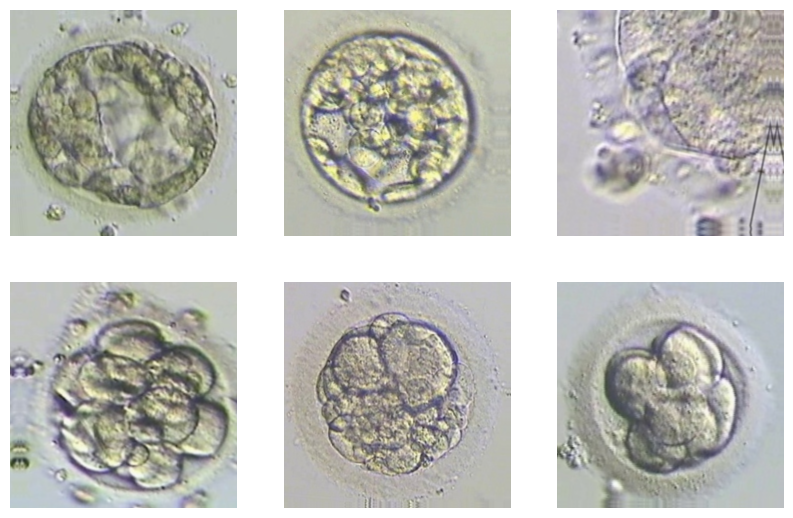

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]/255.)
        plt.axis("off")

## Create `tf.data.Dataset` object

In [ ]:
# Create training and validation Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
# We apply the preprocessing and augmentation to training data
train_ds = train_ds.map(preprocess_image).map(augment).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE)

In [ ]:
# For the validation data, we apply processing only
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE)

In [ ]:
train_ds.cardinality().numpy()

17

# Building CNN model

we use EfficientNet0
- We also use trasfer learning

In [ ]:
input_shape = (IMG_SIZE, IMG_SIZE, 3) # Add a third dimension for RGB channel
base_model = keras.applications.EfficientNetB0(
    input_shape= input_shape,
    include_top=False,
    weights='imagenet'
    )

base_model.trainable = False

In [ ]:
from tensorflow.keras.models import Sequential

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 16, 16, 1280)      4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


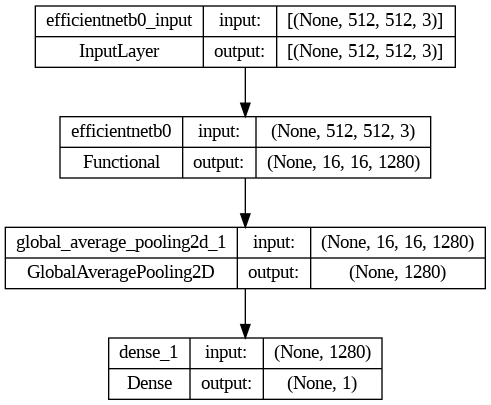

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## Training the CNN

Since we are using a pre-trained model to which we are applying transfer learning, we need to set an optimizer and use callbacks.

In [ ]:
# Optimizer
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10


Plots of the training history:
- Loss
- Accuracy
- Type I error
- Type II error

In [ ]:
def get_metric_history(history):

    keys = [key for key in history.history.keys()]

    # loss
    loss=history.history[keys[0]]
    val_loss=history.history[keys[6]]

    # accuracy
    acc = history.history[keys[1]]
    val_acc = history.history[keys[7]]

    # evaluation metrics
    false_pos = np.array(history.history[keys[2]])
    true_pos = np.array(history.history[keys[3]])
    false_negs = np.array(history.history[keys[4]])
    true_negs = np.array(history.history[keys[5]])

    val_false_pos = np.array(history.history[keys[8]])
    val_true_pos = np.array(history.history[keys[9]])
    val_false_negs = np.array(history.history[keys[10]])
    val_true_negs = np.array(history.history[keys[11]])

    type_1 = np.nan_to_num(false_pos/(false_pos+true_negs), nan=0)
    val_type_1 = np.nan_to_num(val_false_pos/(val_false_pos+val_true_negs))

    type_2 = np.nan_to_num(false_negs/(false_negs+true_pos))
    val_type_2 = np.nan_to_num(val_false_negs/(val_false_negs+val_true_pos))

    metric_history = [loss, val_loss, acc, val_acc, type_1.tolist(),
                      val_type_1.tolist(), type_2.tolist(), val_type_2.tolist()]
    return metric_history


def plot_metric_history(metric_history):
    """Plot loss and metrics history"""
    epochs_range = range(len(metric_history[0]))

    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, metric_history[0], label='Training Loss')
    plt.plot(epochs_range, metric_history[1], '-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, metric_history[2], label='Training Accuracy')
    plt.plot(epochs_range, metric_history[3], '-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, metric_history[4], label='Training Type I Error')
    plt.plot(epochs_range, metric_history[5], '-', label='Validation Type I Error')
    plt.legend(loc='upper right')
    plt.title('Type I Error')

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, metric_history[6], label='Training Type II Error')
    plt.plot(epochs_range, metric_history[7], '-', label='Validation Type II Error')
    plt.legend(loc='upper right')
    plt.title('Type II Error')
    plt.show()
    return

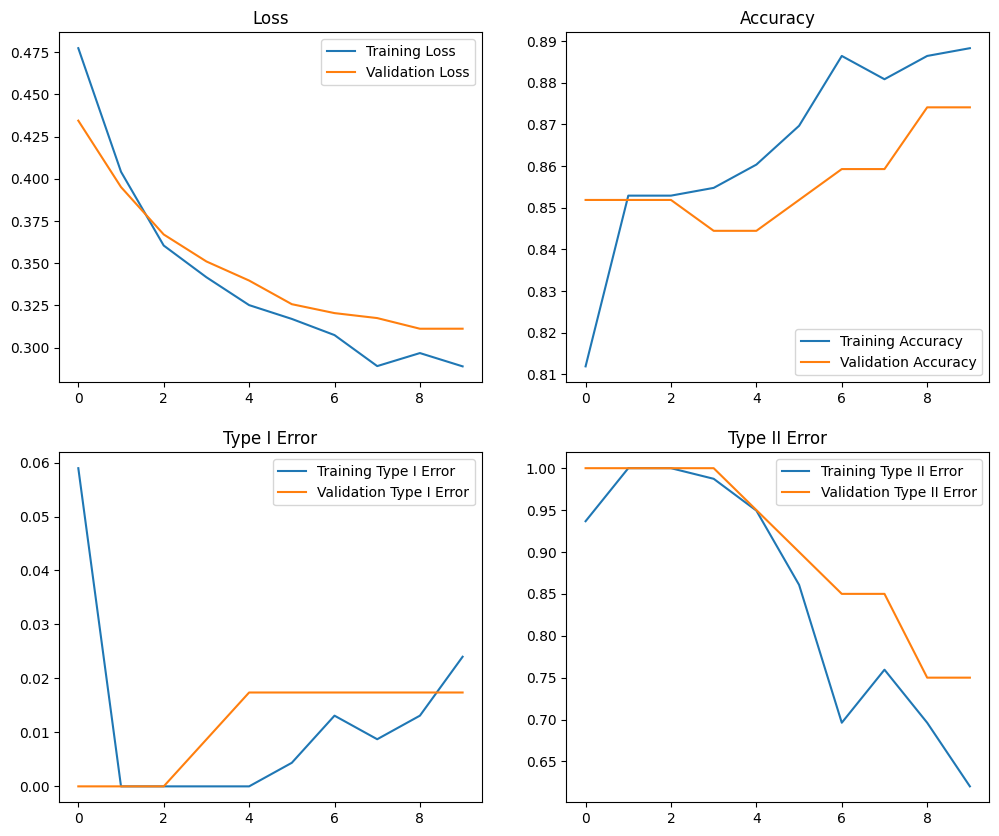

In [ ]:
# Extract training history of phase 1
phase_1_metrics = get_metric_history(phase_1_history)

# Visualize the training history of phase 1
plot_metric_history(phase_1_metrics)

Fine Tuning the CNN

In [ ]:
# Phase 2: Fine tuning
base_model.trainable = True

# We only update parameters from layer 221 onwards
fine_tune_at = 221
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
model.compile(
    optimizer=optimizer(learning_rates[1]),
    loss=loss,
    metrics=metrics
)

# Train the model
phase_2_history = model.fit(
    train_ds,
    epochs=sum(training_epochs),
    initial_epoch=phase_1_history.epoch[-1],
    validation_data = val_ds
)

Epoch 10/40


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


17/17 [==============================] - 432s 25s/step - loss: 0.4689 - binary_accuracy: 0.8393 - false_positives: 74.0000 - true_positives: 65.0000 - false_negatives: 34.0000 - true_negatives: 499.0000 - val_loss: 0.3257 - val_binary_accuracy: 0.8593 - val_false_positives: 2.0000 - val_true_positives: 3.0000 - val_false_negatives: 17.0000 - val_true_negatives: 113.0000
Epoch 11/40
17/17 [==============================] - 377s 22s/step - loss: 0.3071 - binary_accuracy: 0.9050 - false_positives: 13.0000 - true_positives: 41.0000 - false_negatives: 38.0000 - true_negatives: 445.0000 - val_loss: 0.3394 - val_binary_accuracy: 0.8593 - val_false_positives: 3.0000 - val_true_positives: 4.0000 - val_false_negatives: 16.0000 - val_true_negatives: 112.0000
Epoch 12/40
17/17 [==============================] - 395s 23s/step - loss: 0.2877 - binary_accuracy: 0.9050 - false_positives: 5.0000 - true_positives: 33.0000 - false_negatives: 46.0000 - true_negatives: 453.0000 - val_loss: 0.3428 - val_bin

In [ ]:
model.summary()

NameError: ignored

**Kevin's CNN Model**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [ ]:
batch_size = 100
img_height = 300
img_width = 300

In [ ]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/Shareddrives/dataset/embryo-dateset/train',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/Shareddrives/dataset/embryo-dateset/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 672 files belonging to 2 classes.
Found 168 files belonging to 2 classes.


In [ ]:
class_names = training_dataset.class_names
print(class_names)

['0', '1']


In [ ]:
autotune = tf.data.experimental.AUTOTUNE
training_dataset = training_dataset.cache().prefetch(buffer_size=autotune)
testing_dataset = testing_dataset.cache().prefetch(buffer_size=autotune)

# CNN model


In [ ]:
NN_model = models.Sequential()
NN_model.add(layers.Conv2D(32,3, activation='relu', input_shape = (300,300,3)))
NN_model.add(layers.BatchNormalization())
NN_model.add(layers.MaxPooling2D((2,2)))
NN_model.add(layers.Conv2D(32,3, activation='relu'))
NN_model.add(layers.BatchNormalization())
NN_model.add(layers.MaxPooling2D((2,2)))
NN_model.add(layers.Flatten())
NN_model.add(layers.Dense(128, activation='relu'))
NN_model.add(layers.Dense(64, activation='relu'))
NN_model.add(layers.Dense(2, activation='sigmoid'))

In [ ]:
NN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 298, 298, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 147, 147, 32)      128       
 chNormalization)                                                
                                                        

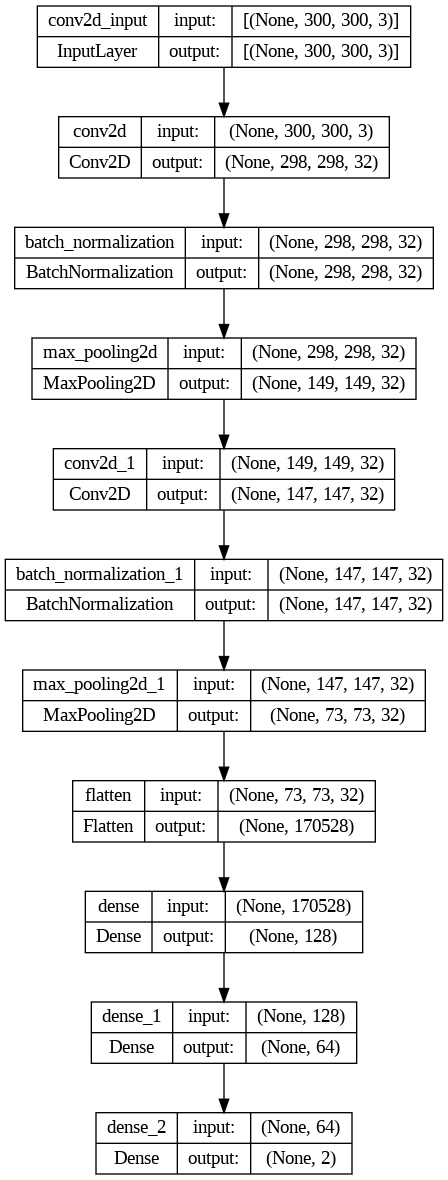

In [ ]:
keras.utils.plot_model(NN_model, show_shapes=True)

In [ ]:
history = NN_model.fit(training_dataset, validation_data = testing_dataset, epochs = 20)

Epoch 1/20
7/7 [==============================] - 128s 17s/step - loss: 5.0321 - accuracy: 0.7976 - val_loss: 8.2184 - val_accuracy: 0.8512
Epoch 2/20
7/7 [==============================] - 108s 16s/step - loss: 1.4988 - accuracy: 0.8378 - val_loss: 96.9045 - val_accuracy: 0.1488
Epoch 3/20
7/7 [==============================] - 122s 18s/step - loss: 0.4235 - accuracy: 0.9345 - val_loss: 23.4469 - val_accuracy: 0.8512
Epoch 4/20
7/7 [==============================] - 114s 16s/step - loss: 0.1291 - accuracy: 0.9777 - val_loss: 14.1553 - val_accuracy: 0.8512
Epoch 5/20
7/7 [==============================] - 113s 16s/step - loss: 0.0915 - accuracy: 0.9896 - val_loss: 5.9613 - val_accuracy: 0.8512
Epoch 6/20
7/7 [==============================] - 109s 16s/step - loss: 0.0372 - accuracy: 0.9940 - val_loss: 8.3498 - val_accuracy: 0.8512
Epoch 7/20
7/7 [==============================] - 112s 16s/step - loss: 0.0262 - accuracy: 0.9970 - val_loss: 8.1756 - val_accuracy: 0.8512
Epoch 8/20
7/7 [=

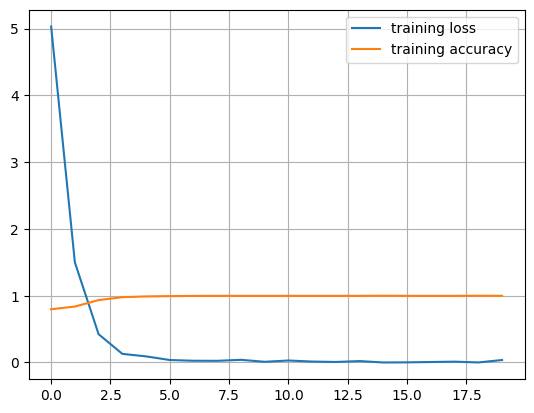

In [ ]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

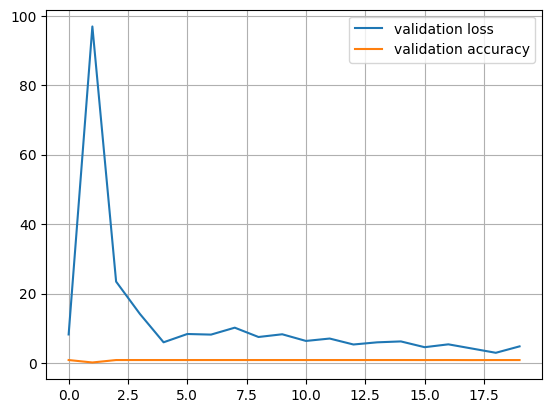

In [ ]:
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

3/3 [==============================] - 3s 679ms/step


<Axes: title={'center': 'Confusion matrix'}>

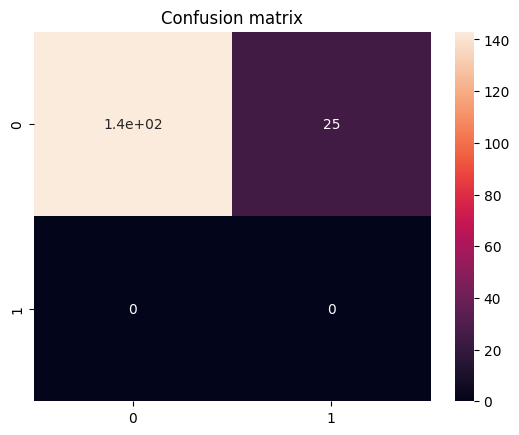

In [ ]:
true_prediction = []
test_prediction = []

for predicts, labels in testing_dataset:
    predictions = NN_model.predict(predicts)
    prediction_labels = np.argmax(predictions, axis=1)

    true_prediction.extend(labels.numpy())
    test_prediction.extend(prediction_labels)

cm = confusion_matrix(test_prediction, true_prediction)
ax = plt.axes()
ax.set_title("Confusion matrix")

sn.heatmap(cm, annot=True, yticklabels=class_names,xticklabels=class_names)

**Henil's Model**

Import all relevant packages and libraries of Python and also modules in the Google Drive.

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing
import tensorflow as tf
import tensorflow.keras as keras
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50

Dataset is located in a sharedrive.
- embryo-dataset



In [ ]:
cd /content/gdrive/Shareddrives/dataset/embryo-dateset

/content/gdrive/Shareddrives/dataset/embryo-dateset


Dataset containes 2 folders:
- test
- train

In [ ]:
ls

model.png  test/  train/


In [ ]:
# Function to get images
def read_ct_scan(folder_name):
    """Read the scan image files from directory"""
    images = []

    # Construct path for two image file folders
    filepaths = [os.path.join(folder_name,file) for file in os.listdir(folder_name) if file != '.DS_Store']

    # Read image file in each folder and convert them to RGB channel
    for file in filepaths:
        images.append(np.array(Image.open(file).convert('RGB')))

    return images


Getting training images
- 0 = embryo is no good
- 1 = embryo

In [ ]:
base_path = os.path.join(os.getcwd(), 'train')

not_good_embryo = read_ct_scan(os.path.join(base_path, '0'))
good_embryo = read_ct_scan(os.path.join(base_path, '1'))

print('Total number of images: ')
print('Good: ', len(good_embryo))
print('No good: ', len(not_good_embryo))

Total number of images: 
Good:  99
No good:  573


### Examples of good Embryo: 1

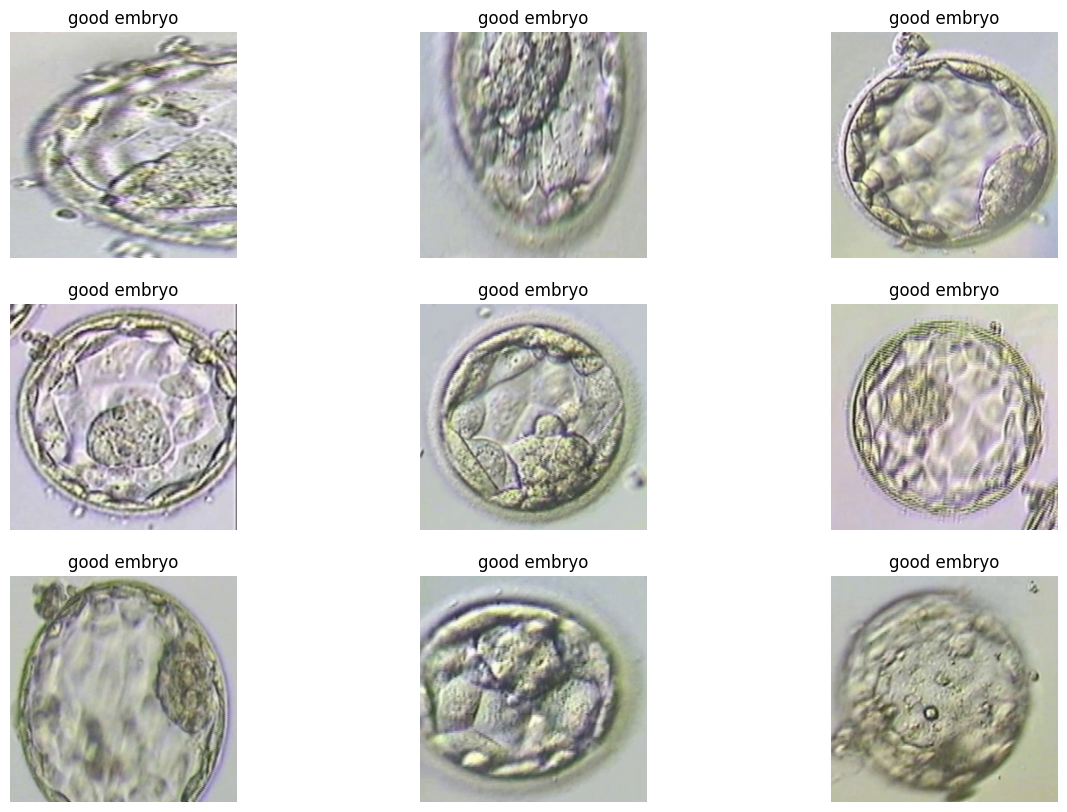

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(good_embryo[i]/255.)
    plt.axis("off")
    plt.title('good embryo')

### Example of a bad embryo: 0

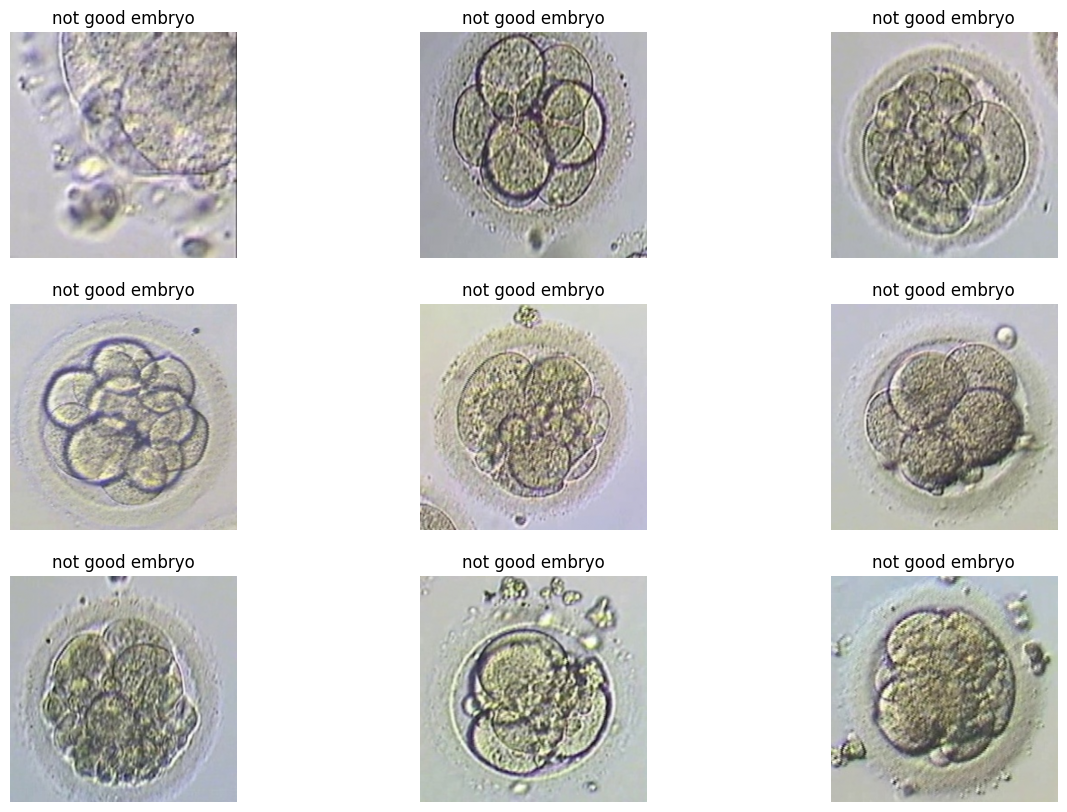

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(not_good_embryo[i]/255.)
    plt.axis("off")
    plt.title('not good embryo')

Let's create binary label for good embryo and no good embryo

In [ ]:
notGood_labels = np.full(len(not_good_embryo),fill_value=0)
good_labels = np.full(len(good_embryo),fill_value=1)

## Train-validation split

In [ ]:
# Train-validation split while keeping the order of the images
train_data_portion = 0.70 # Proportion of data for training

# Get integer number of training samples
train_good_size = round(len(good_embryo)*train_data_portion)
train_notgood_size = round(len(not_good_embryo)*train_data_portion)

# Split the dataset in its original sequence
X_train = not_good_embryo[:train_notgood_size] + good_embryo[:train_good_size]
y_train = np.concatenate((notGood_labels[:train_notgood_size],
                          good_labels[:train_good_size]))

X_val = not_good_embryo[train_notgood_size:] + good_embryo[train_good_size:]
y_val = np.concatenate((notGood_labels[train_notgood_size:],
                        good_labels[train_good_size:]))

print('Train-validation split:')
print('{} training images and {} validation images'.format(len(X_train), len(X_val)))

Train-validation split:
470 training images and 202 validation images


## Create `tf.data.Dataset` object

In [ ]:
def resize_and_shuffle(X, y, img_size=(512,512), batch_size=32, seed=123, buffer_size=500):
    """
    Resize image files to equal height and width of IMG_SIZE,
    Convert data to tensorflow.data.Dataset objects with random shuffle and batches
    """
    results = list(map(lambda img: tf.image.resize(img, img_size), X))
    results = tf.data.Dataset.from_tensor_slices((results, y))
    ds = results.shuffle(len(y)).batch(batch_size)

    return ds

In [ ]:
# Define global variables
IMG_SIZE = (512,512) # Standardize all images to this size
BATCH_SIZE = 32 # Number of training images for each gradient update
RANDOM_SEED = 123 # Random seed to ensure reproducibility

# Create training and validation Dataset objects
train_ds = resize_and_shuffle(X_train, y_train, img_size=IMG_SIZE)
val_ds = resize_and_shuffle(X_val, y_val, img_size=IMG_SIZE)

In [ ]:
train_ds.cardinality().numpy() # numpy is a python library to do mathematical operations

15

## Data Augmentation

Using `tf.keras.Sequential` to create a pipeline in which the input image is randomly transformed through the following operations:
1. Random horizontal and vertical flip
2. Rotation by a random degree in the range of $[-5\%, 5\%]*2\pi$
3. Random zoom in height by $5\%$
4. Random translation by $5\%$
5. Random contrast adjustment by $5\%$

In [ ]:
# Create data augmentation pipeline
augmentation_pipeline = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomRotation((-0.05, 0.05), seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomZoom(-0.05, seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomTranslation(0.05, 0.05, seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomContrast(0.05, seed=RANDOM_SEED),
    ]
)

# Augment training data using augmentation pipeline
augmented_train_ds = train_ds.map(
    lambda x, y: (augmentation_pipeline(x, training=True), y))
train_ds = augmented_train_ds

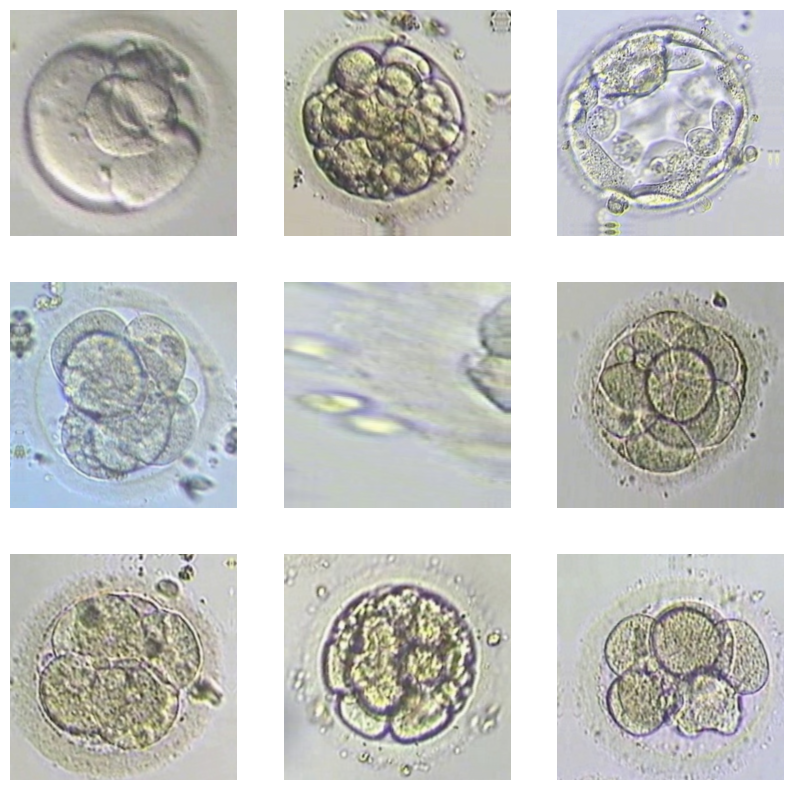

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]/255.)
        plt.axis("off")

# Building CNN model

# CNN model 1

Used ResNet50

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,) # Add a third dimension for RGB channel
base_model = keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False)
base_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = keras.Input(shape=IMG_SHAPE) # Input layer

x = base_model(inputs) # ResNet50
x = layers.GlobalAveragePooling2D()(x) # Pooling layer
x = layers.Dropout(0.1)(x) # Dropout layer

outputs = layers.Dense(1, activation="sigmoid")(x) # Classification layer
# sigmoid activation function normalizes negative points to 0

# Build the model
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
__________________

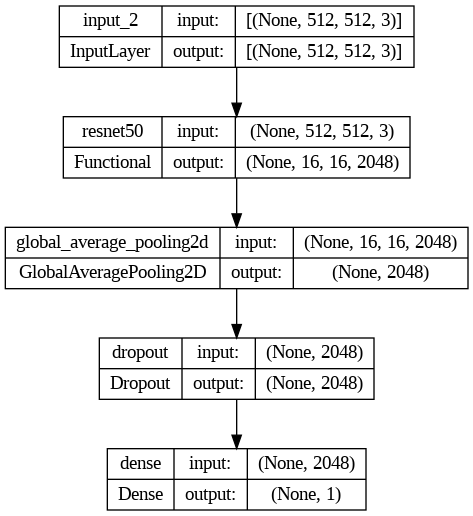

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## Training the CNN

In [ ]:
# Specify metrics, loss function, and optimizer
metrics =[keras.metrics.BinaryAccuracy(), keras.metrics.FalsePositives(),
            keras.metrics.TruePositives(), keras.metrics.FalseNegatives(),
            keras.metrics.TrueNegatives()]
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam

# Create learning rates for two phases of training
learning_rates = [1e-3, 1e-4]

In [ ]:
# Setting the number of training epochs
training_epochs = [10, 20]

Phase 1: ResNets fixed

In [ ]:
# Phase 1: ResNets'weights fixed

# Compile the model
model.compile(
    optimizer=optimizer(learning_rates[0]),
    loss=loss,
    metrics=metrics,
)

# Train the model
phase_1_history = model.fit(
    train_ds,
    epochs=training_epochs[0],
    validation_data=val_ds
)

Epoch 1/10
15/15 [==============================] - 877s 59s/step - loss: 0.4075 - binary_accuracy: 0.8352 - false_positives: 13.0000 - true_positives: 5.0000 - false_negatives: 75.0000 - true_negatives: 441.0000 - val_loss: 0.3637 - val_binary_accuracy: 0.8713 - val_false_positives: 0.0000e+00 - val_true_positives: 4.0000 - val_false_negatives: 26.0000 - val_true_negatives: 172.0000
Epoch 2/10
15/15 [==============================] - 841s 57s/step - loss: 0.3364 - binary_accuracy: 0.8638 - false_positives: 6.0000 - true_positives: 11.0000 - false_negatives: 58.0000 - true_negatives: 395.0000 - val_loss: 0.3547 - val_binary_accuracy: 0.8515 - val_false_positives: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_negatives: 30.0000 - val_true_negatives: 172.0000
Epoch 3/10
15/15 [==============================] - 838s 57s/step - loss: 0.2766 - binary_accuracy: 0.8830 - false_positives: 5.0000 - true_positives: 19.0000 - false_negatives: 50.0000 - true_negatives: 396.0000 - val_los

Plots of the training history:
- Loss
- Accuracy
- Type I error
- Type II error

In [ ]:
def get_metric_history(history):

    keys = [key for key in history.history.keys()]

    # loss
    loss=history.history[keys[0]]
    val_loss=history.history[keys[6]]

    # accuracy
    acc = history.history[keys[1]]
    val_acc = history.history[keys[7]]

    # evaluation metrics
    false_pos = np.array(history.history[keys[2]])
    true_pos = np.array(history.history[keys[3]])
    false_negs = np.array(history.history[keys[4]])
    true_negs = np.array(history.history[keys[5]])

    val_false_pos = np.array(history.history[keys[8]])
    val_true_pos = np.array(history.history[keys[9]])
    val_false_negs = np.array(history.history[keys[10]])
    val_true_negs = np.array(history.history[keys[11]])

    type_1 = np.nan_to_num(false_pos/(false_pos+true_negs), nan=0)
    val_type_1 = np.nan_to_num(val_false_pos/(val_false_pos+val_true_negs))

    type_2 = np.nan_to_num(false_negs/(false_negs+true_pos))
    val_type_2 = np.nan_to_num(val_false_negs/(val_false_negs+val_true_pos))

    metric_history = [loss, val_loss, acc, val_acc, type_1.tolist(),
                      val_type_1.tolist(), type_2.tolist(), val_type_2.tolist()]
    return metric_history


def plot_metric_history(metric_history):
    """Plot loss and metrics history"""
    epochs_range = range(len(metric_history[0]))

    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, metric_history[0], label='Training Loss')
    plt.plot(epochs_range, metric_history[1], '-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, metric_history[2], label='Training Accuracy')
    plt.plot(epochs_range, metric_history[3], '-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, metric_history[4], label='Training Type I Error')
    plt.plot(epochs_range, metric_history[5], '-', label='Validation Type I Error')
    plt.legend(loc='upper right')
    plt.title('Type I Error')

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, metric_history[6], label='Training Type II Error')
    plt.plot(epochs_range, metric_history[7], '-', label='Validation Type II Error')
    plt.legend(loc='upper right')
    plt.title('Type II Error')
    plt.show()
    return

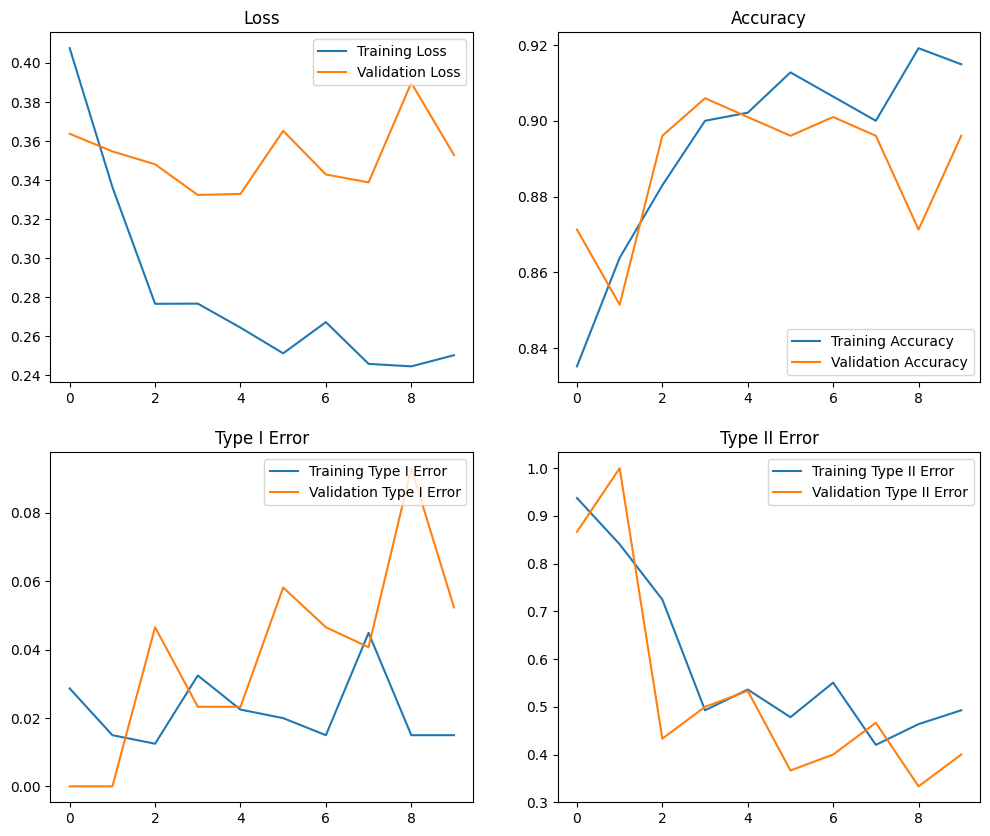

In [ ]:
# Extract training history of phase 1
phase_1_metrics = get_metric_history(phase_1_history)

# Visualize the training history of phase 1
plot_metric_history(phase_1_metrics)